# Supervised Learning Final Project Problem Description
## Using regression and classification to predict the numerical rating of white wine quality on an integer scale

Some machine learning problems have response variables that are neither categorical nor continuous but take on discrete integer variables. One common application of this is predicting the user rating for some consumable item based on other measurable characteristics. For these problems, regression suffers from inexact approximations due to rounding that must be done after fitting, while multi-class classification suffers from an inexactness in the loss function - a predicted rating of "6" when the correct rating is "5" will be weighted no differently than a predicted rating of "2" for the same "5" rating, meaning that the model fit parameters do not necessarily minimize the correct loss function. I researched other methods for dealing with this type of data, and found a paper on "ordinal classification" which proposes an algorithm that is supposed to be more accurate than multi-class classification by treating the classification problem as a weighted series of binary class classifications.

This project uses white wine data from the [UCI Wine Quality dataset](http://archive.ics.uci.edu/dataset/186/wine+quality) to test these three different methods of dealing with integer response variables: Regression, Multi-class Classification, and Ordinal classification and compare the root-mean-square error from various models, to determine which of the methods works best for this data set.

# Imports and utility functions

In [4]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns

# Helper functions
import statsmodels.formula.api as smf
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV

# Models
from sklearn.base import BaseEstimator, clone
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

### Ordinal Classifier Class

This method is not available in scikit-learn as of version 1.5.2, and there is an open ticket from 2022 on the official github page requesting that this functionality be added. However, I was able to track down an implementation of the algorithm (linked in the references), which I was able to adapt to my own purposes. This implementation is compatible with the sklearn estimator class, from which the regression and classification classes are derived.

In [6]:
class OrdinalClassifier(BaseEstimator):

    def __init__(self, clf):
        self.clf = clf
        self.clfs = {}

    def fit(self, X, y):
        self.unique_class = np.sort(np.unique(y))
        if self.unique_class.shape[0] > 2:
            for i in range(self.unique_class.shape[0]-1):
                # for each k - 1 ordinal value we fit a binary classification problem
                binary_y = (y > self.unique_class[i]).astype(np.uint8)
                clf = clone(self.clf)
                try:
                  clf.module
                except: # For others
                  clf.fit(X, binary_y)
                else: # For MLP
                  binary_y_reshape = binary_y.astype('float32').reshape(-1,1)
                  clf.fit(X, binary_y_reshape)
                self.clfs[i] = clf

    def predict_proba(self, X):
        clfs_predict = {k: self.clfs[k].predict_proba(X) for k in self.clfs}
        predicted = []
        for i, y in enumerate(self.unique_class):
            if i == 0:
                # V1 = 1 - Pr(y > V1)
                predicted.append(1 - clfs_predict[i][:,1])
            elif i in clfs_predict:
                # Vi = Pr(y > Vi-1) - Pr(y > Vi)
                 predicted.append(clfs_predict[i-1][:,1] - clfs_predict[i][:,1])
            else:
                # Vk = Pr(y > Vk-1)
                predicted.append(clfs_predict[i-1][:,1])
        try:
          self.clf.module
        except: # For others
          pred_proba = np.vstack(predicted).T      
        else: # For MLP
          pred_proba = np.hstack((predicted))
        
        return pred_proba

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

# EDA

This data comes from the UCI and so should largely already be clean, which is one of the advantages of public data sets. However, we should still examine the distribution and determine if there is any significant correlation between our desired variable (quality) and any of the other variables before using an ensemble model such as a random forest.

In [8]:
# data load
data = pd.read_csv('winequality-white.csv')
print(data.head)

<bound method NDFrame.head of       fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0               7.0              0.27         0.36            20.7      0.045   
1               6.3              0.30         0.34             1.6      0.049   
2               8.1              0.28         0.40             6.9      0.050   
3               7.2              0.23         0.32             8.5      0.058   
4               7.2              0.23         0.32             8.5      0.058   
...             ...               ...          ...             ...        ...   
4893            6.2              0.21         0.29             1.6      0.039   
4894            6.6              0.32         0.36             8.0      0.047   
4895            6.5              0.24         0.19             1.2      0.041   
4896            5.5              0.29         0.30             1.1      0.022   
4897            6.0              0.21         0.38             0.8      0.020  

## Visualization

array([[<Axes: title={'center': 'fixed_acidity'}>],
       [<Axes: title={'center': 'volatile_acidity'}>],
       [<Axes: title={'center': 'citric_acid'}>],
       [<Axes: title={'center': 'residual_sugar'}>],
       [<Axes: title={'center': 'chlorides'}>],
       [<Axes: title={'center': 'free_sulfur_dioxide'}>],
       [<Axes: title={'center': 'total_sulfur_dioxide'}>],
       [<Axes: title={'center': 'density'}>],
       [<Axes: title={'center': 'pH'}>],
       [<Axes: title={'center': 'sulphates'}>],
       [<Axes: title={'center': 'alcohol'}>],
       [<Axes: title={'center': 'quality'}>]], dtype=object)

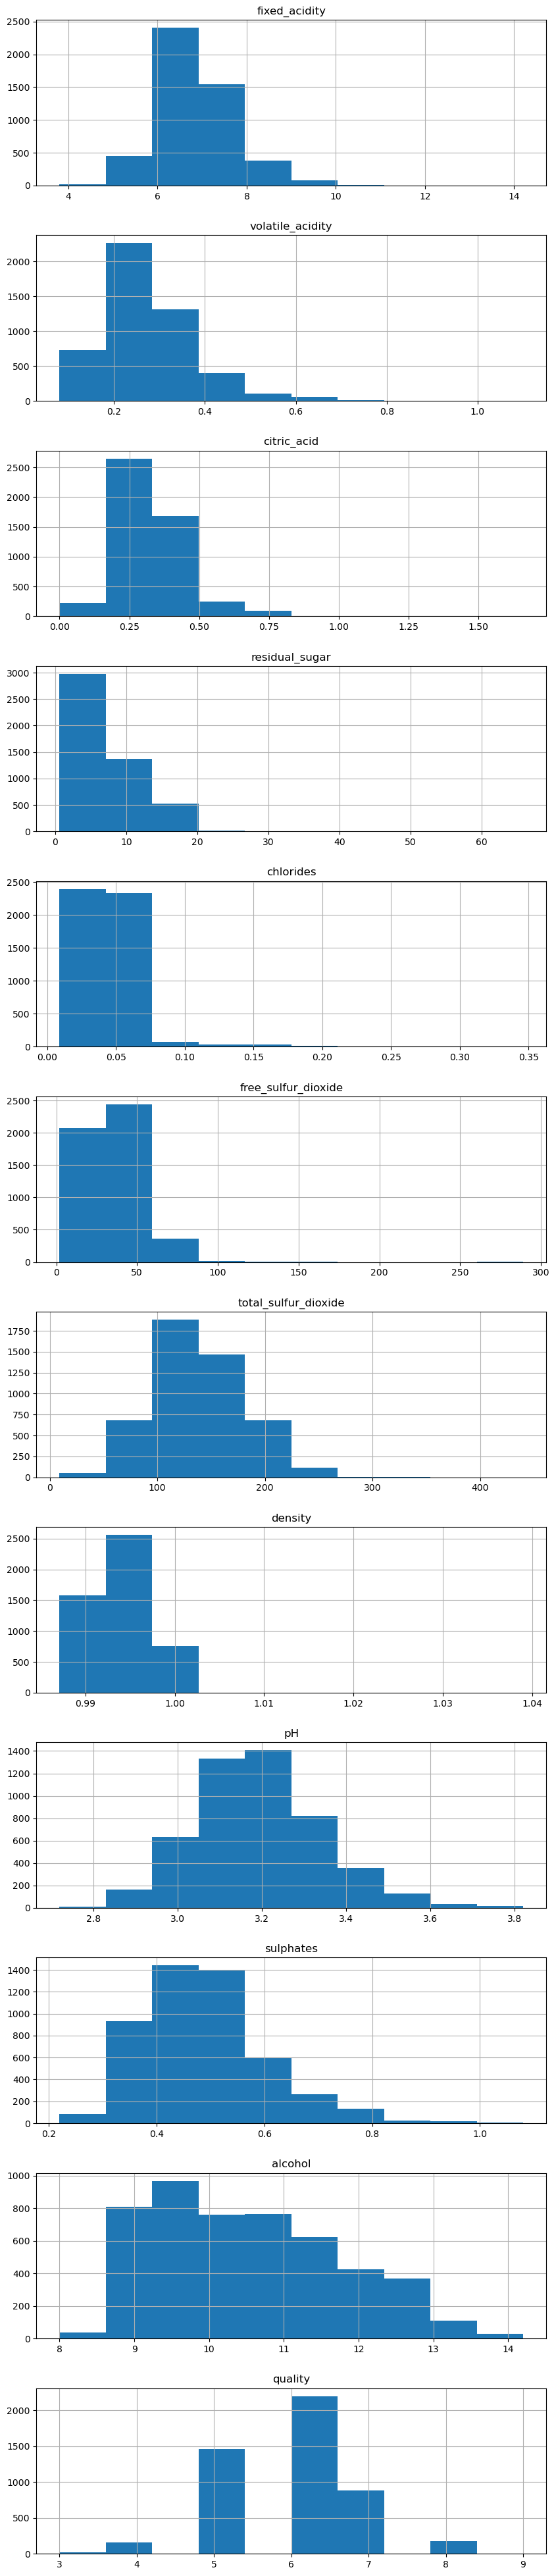

In [10]:
data.hist(layout=(12,1),figsize=(10,50))

## Data Cleaning

In [12]:
data['quality'] = data['quality']-3

## Correlation

<Axes: >

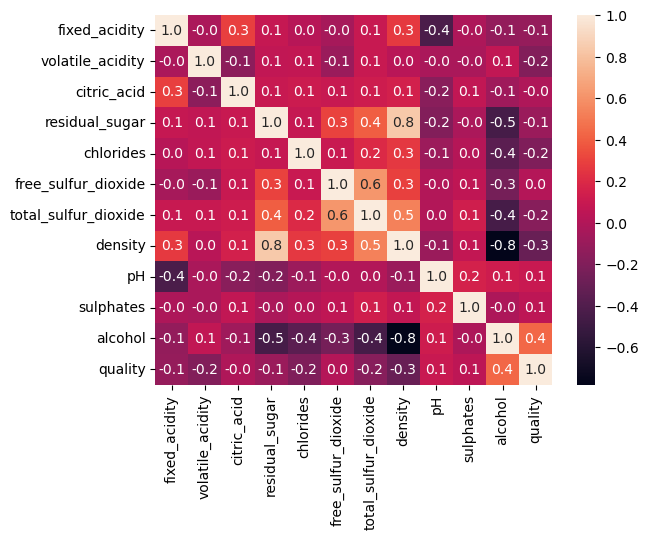

In [14]:
sns.heatmap(data.corr(),annot=True, fmt=".1f")

## Multi-linear regression

Before building a non-parametric predictive model, we will use a linear regression to investigate if any combination of the features are strongly correlated with quality.

In [16]:
allowed_factors = data.columns.drop('quality')
print(allowed_factors)
# K = 1
best = ['',0]
for p in allowed_factors:
    model  = smf.ols(formula='quality~'+p, data = data).fit()
    print(p, model.rsquared)
    if model.rsquared>best[1]:
        best = [p, model.rsquared]
print('best:',best)

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')
fixed_acidity 0.012919239085696366
volatile_acidity 0.03791703462546081
citric_acid 8.480735490989932e-05
residual_sugar 0.00952123753714429
chlorides 0.04407245689956307
free_sulfur_dioxide 6.655405919009372e-05
total_sulfur_dioxide 0.030533095213563288
density 0.09432472922515489
pH 0.009885777194779122
sulphates 0.002881314493482723
alcohol 0.18972533274925651
best: ['alcohol', 0.18972533274925651]


In [17]:
# K = 2
best = ['',0]
for p in allowed_factors:
    model  = smf.ols(formula='quality~alcohol+'+p, data = data).fit()
    print(p, model.rsquared)
    if model.rsquared>best[1]:
        best = [p, model.rsquared]
print('best:',best)

fixed_acidity 0.19350275804257733
volatile_acidity 0.2402311847533617
citric_acid 0.19029391204459845
residual_sugar 0.2019510008159675
chlorides 0.1929586104256874
free_sulfur_dioxide 0.20435197005222794
total_sulfur_dioxide 0.19026656977710077
density 0.19245487662184735
pH 0.19192320109687588
sulphates 0.19348062802892418
alcohol 0.18972533274925651
best: ['volatile_acidity', 0.2402311847533617]


In [18]:
# K = 3
best = ['',0]
for p in allowed_factors:
    model  = smf.ols(formula='quality~alcohol+volatile_acidity+'+p, data = data).fit()
    print(p, model.rsquared)
    if model.rsquared>best[1]:
        best = [p, model.rsquared]
print('best:',best)

fixed_acidity 0.2444251201319788
volatile_acidity 0.2402311847533617
citric_acid 0.24030961624094338
residual_sugar 0.25852615806597845
chlorides 0.24139567574890253
free_sulfur_dioxide 0.2507712371048686
total_sulfur_dioxide 0.24313806051114806
density 0.24690635619896462
pH 0.24166031225998164
sulphates 0.24309658826833824
alcohol 0.2402311847533617
best: ['residual_sugar', 0.25852615806597845]


We can clearly see that there is no clear linear relationship between any of the variables and quality.

# Model / Analysis

In [21]:
# First, we will split the data into a training and testing set
X = data.drop(['quality'], axis=1)
y = data['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=5)

## Baseline

In order to compare these models predictive ability, we need to establish a baseline, in this case rating every wine the average of the entire dataset

In [23]:
y_pred = [np.mean(y_test) for y in y_test]
y_pred_round = [round(y) for y in y_pred]
print('RMSE:',root_mean_squared_error(y_pred,y_test))
print('RMSE with rounding:',root_mean_squared_error(y_pred_round,y_test))

RMSE: 0.8773889916231453
RMSE with rounding: 0.8869499848246829


## Regression

In [25]:
regr = DecisionTreeRegressor(random_state=42)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
y_pred_round = [round(y) for y in y_pred]
print('RMSE:',root_mean_squared_error(y_pred,y_test))
print('RMSE with rounding:',root_mean_squared_error(y_pred_round,y_test))

RMSE: 1.0076259365798326
RMSE with rounding: 1.0076259365798326


In [26]:
est = DecisionTreeRegressor(random_state=42)
param_grid = {'max_depth':[i for i in range(1,20)]}

cv = GridSearchCV(est, param_grid, scoring = 'neg_root_mean_squared_error')
cv.fit(X_train,y_train)
y_pred = cv.best_estimator_.predict(X_test)
y_pred_round = [round(y) for y in y_pred]
print('RMSE:',root_mean_squared_error(y_pred,y_test))
print('RMSE with rounding:',root_mean_squared_error(y_pred_round,y_test))

RMSE: 0.7745113914491052
RMSE with rounding: 0.8278761520871902


In [27]:
print(cv.best_estimator_.get_params())

{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}


In [28]:
regr = RandomForestRegressor(random_state=42)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
y_pred_round = [round(y) for y in y_pred]
print('RMSE:',root_mean_squared_error(y_pred,y_test))
print('RMSE with rounding:',root_mean_squared_error(y_pred_round,y_test))
print(cv.best_estimator_.get_params())

RMSE: 0.6977538965334293
RMSE with rounding: 0.7429175673419439
{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}


In [29]:
est = RandomForestRegressor(random_state=42)
param_grid = {'n_estimators':[50*i for i in range(1,6)],
              'max_depth':[i for i in range(1,20)]}

cv = GridSearchCV(est, param_grid, scoring = 'neg_root_mean_squared_error')
cv.fit(X_train,y_train)
y_pred = cv.best_estimator_.predict(X_test)
y_pred_round = [round(y) for y in y_pred]
print('RMSE:',root_mean_squared_error(y_pred,y_test))
print('RMSE with rounding:',root_mean_squared_error(y_pred_round,y_test))
print(cv.best_estimator_.get_params())

RMSE: 0.6947256494159034
RMSE with rounding: 0.7458313168212461
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 13, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 150, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


## Classification

In [31]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('RMSE:',root_mean_squared_error(y_pred,y_test))

RMSE: 0.9978287221331914


In [32]:
est = DecisionTreeClassifier(random_state=42)
param_grid = {'max_depth':[i for i in range(1,20)]}

cv = GridSearchCV(est, param_grid, scoring = 'neg_root_mean_squared_error')
cv.fit(X_train,y_train)
y_pred = cv.best_estimator_.predict(X_test)
y_pred_round = [round(y) for y in y_pred]
print('RMSE:',root_mean_squared_error(y_pred,y_test))
print(cv.best_estimator_.get_params())

C:\Users\Nate\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


RMSE: 0.8364617640545113
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}


In [33]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('RMSE:',root_mean_squared_error(y_pred,y_test))

RMSE: 0.7541667870839281


In [34]:
est = RandomForestClassifier(random_state=42)
param_grid = {'n_estimators':[50*i for i in range(1,6)], 
              'max_depth':[i for i in range(1,20)]}

cv = GridSearchCV(est, param_grid, scoring = 'neg_root_mean_squared_error')
cv.fit(X_train,y_train)
y_pred = cv.best_estimator_.predict(X_test)
y_pred_round = [round(y) for y in y_pred]
print('RMSE:',root_mean_squared_error(y_pred,y_test))
print(cv.best_estimator_.get_params())

C:\Users\Nate\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


RMSE: 0.7575426624487605
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 12, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 150, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


## Ordinal Classification

In [36]:
clf = OrdinalClassifier(DecisionTreeClassifier(random_state=42))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('RMSE:',root_mean_squared_error(y_pred,y_test))

RMSE: 0.9389368720017821


In [37]:
est = OrdinalClassifier(DecisionTreeClassifier(random_state=42))
param_grid = {'clf__max_depth':[i for i in range(1,20)]}

cv = GridSearchCV(est, param_grid, scoring = 'neg_root_mean_squared_error')
cv.fit(X_train,y_train)
y_pred = cv.best_estimator_.predict(X_test)
y_pred_round = [round(y) for y in y_pred]
print('RMSE:',root_mean_squared_error(y_pred,y_test))
print(cv.best_estimator_.get_params())

RMSE: 0.8449601424065383
{'clf__ccp_alpha': 0.0, 'clf__class_weight': None, 'clf__criterion': 'gini', 'clf__max_depth': 2, 'clf__max_features': None, 'clf__max_leaf_nodes': None, 'clf__min_impurity_decrease': 0.0, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__min_weight_fraction_leaf': 0.0, 'clf__monotonic_cst': None, 'clf__random_state': 42, 'clf__splitter': 'best', 'clf': DecisionTreeClassifier(max_depth=2, random_state=42)}


In [38]:
ordclf = OrdinalClassifier(RandomForestClassifier(random_state=42))
ordclf.fit(X_train, y_train)
y_pred = ordclf.predict(X_test)
print('RMSE:',root_mean_squared_error(y_pred,y_test))

RMSE: 0.782723635691337


In [39]:
est = OrdinalClassifier(RandomForestClassifier(random_state=42))
param_grid = {'clf__n_estimators':[50*i for i in range(1,6)], 
              'clf__max_depth':[i for i in range(1,20)]}

cv = GridSearchCV(est, param_grid, scoring = 'neg_root_mean_squared_error')
cv.fit(X_train,y_train)
y_pred = cv.best_estimator_.predict(X_test)
y_pred_round = [round(y) for y in y_pred]
print('RMSE:',root_mean_squared_error(y_pred,y_test))
print(cv.best_estimator_.get_params())

RMSE: 0.7715600590528875
{'clf__bootstrap': True, 'clf__ccp_alpha': 0.0, 'clf__class_weight': None, 'clf__criterion': 'gini', 'clf__max_depth': 15, 'clf__max_features': 'sqrt', 'clf__max_leaf_nodes': None, 'clf__max_samples': None, 'clf__min_impurity_decrease': 0.0, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__min_weight_fraction_leaf': 0.0, 'clf__monotonic_cst': None, 'clf__n_estimators': 250, 'clf__n_jobs': None, 'clf__oob_score': False, 'clf__random_state': 42, 'clf__verbose': 0, 'clf__warm_start': False, 'clf': RandomForestClassifier(max_depth=15, n_estimators=250, random_state=42)}


# Results

|Method|RMSE (to 3 decimals)|
|:----|:--------:|
|Baseline, mean(y)| .877 |
|Baseline, mean(y) (rounded) | .887 |
|Regression, one tree| .775 |
|Regression, one tree (rounded)| .828 |
|Regression, random forest | .695 |
|Regression, random forest (rounded) | .746 |
|Classification, one tree| .836 |
|Classification, random forest | .758 |
|Ordinal method, one tree | .845 |
|Ordinal method, random forest | .771 |



# Discussion / Conclusion

This project used random forests to build a model to predict the numerical quality rating of white wine in the UCI dataset based on chemical properties. Since this output variable is an integer, three different methods were used: regression, multi-class classification, and "ordinal" classification, which was developed specifically to handle this sort of output response variable. While the regression method does perform numerically better, those improvements are mostly erased upon rounding the output to the nearest integer, however it did still outperform both multi-class classification and ordinal classification for this data set. Despite allegedly being designed to use this specific kind of data, the Ordinal classification consistently performed the worst of all, which may suggest why this method is not in widespread use and has not been implemented yet in scikit-learn.

# References

1. [Response is an Integer. Should I use classification or regression? on StackExchange](https://stats.stackexchange.com/questions/282803/response-is-an-integer-should-i-use-classification-or-regression)
3. [Frank, E., Hall, M. (2001). A Simple Approach to Ordinal Classification. In: De Raedt, L., Flach, P. (eds) Machine Learning: ECML 2001. ECML 2001. Lecture Notes in Computer Science(), vol 2167. Springer, Berlin, Heidelberg. https://doi.org/10.1007/3-540-44795-4_13 (PDF)](https://link.springer.com/chapter/10.1007/3-540-44795-4_13)
4. [Ticket for Ordinal Classification Support in sklearn](https://github.com/scikit-learn/scikit-learn/issues/23324)
5. [Implementation of ordinal classification in sklearn](https://www.kaggle.com/code/jayahn0104/ordinal-classification-tune-sklearn-skorch)